# Описание

## Задачи
_Испольуется три задачи:_
- DM -- двухальтернативный выбор
- Romo -- сравнение двух сигнало через задержку
- CtxDM -- DM с контекстом
Вход состоит из одного контекстного входа, одного стимула, 6 входов, кодирующих задачи. Выход как и раньше состоит из трех частей: контекстный выход, выходы принятия решения.

## Сеть
 Сеть состоит из lif AdEx нейронов

# Импорт всех необходимых библиотек

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from cgtasknet.instruments.instrument_accuracy_network import CorrectAnswerNetwork
from cgtasknet.tasks.reduce import (
    CtxDMTaskParameters,
    DMTaskParameters,
    DMTaskRandomModParameters,
    GoDlTaskParameters,
    GoDlTaskRandomModParameters,
    GoRtTaskParameters,
    GoRtTaskRandomModParameters,
    GoTaskParameters,
    GoTaskRandomModParameters,
    MultyReduceTasks,
    RomoTaskParameters,
    RomoTaskRandomModParameters,
)
from tqdm import tqdm

# Определяем устройство

In [3]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
print(f"{device}")

cpu


# Функция построения входов и выходов

In [4]:
import os


def plot_results(inputs, target_outputs, outputs):
    if isinstance(inputs, torch.Tensor) and isinstance(target_outputs, torch.Tensor):
        inputs, t_outputs = (
            inputs.detach().cpu().numpy(),
            target_outputs.detach().cpu().numpy(),
        )
    for bath in range(min(batch_size, 20)):
        fig = plt.figure(figsize=(15, 3))
        ax1 = fig.add_subplot(141)
        plt.title("Inputs")
        plt.xlabel("$time, ms$")
        plt.ylabel("$Magnitude$")
        for i in range(3):
            plt.plot(inputs[:, bath, i].T, label=rf"$in_{i + 1}$")
        plt.legend()
        plt.tight_layout()

        ax2 = fig.add_subplot(142)
        plt.title("Task code (context)")
        plt.xticks(np.arange(1, len(tasks) + 1), sorted(tasks), rotation=90)
        plt.yticks([])
        for i in range(3, inputs.shape[-1]):
            plt.plot([i - 2] * 2, [0, inputs[0, bath, i]])
        plt.tight_layout()

        ax3 = fig.add_subplot(143)
        plt.title("Target output")
        plt.xlabel("$time, ms$")
        for i in range(t_outputs.shape[-1]):
            plt.plot(t_outputs[:, bath, i], label=rf"$out_{i + 1}$")
        plt.legend()
        plt.tight_layout()

        ax4 = fig.add_subplot(144)
        plt.title("Real output")
        plt.xlabel("$time, ms$")
        for i in range(outputs.shape[-1]):
            plt.plot(
                outputs.detach().cpu().numpy()[:, bath, i], label=rf"$out_{i + 1}$"
            )
        plt.legend()
        plt.tight_layout()
        if not os.path.exists("figures"):
            os.mkdir("figures")
        plt.savefig(f"figures{os.sep}network_outputs_{name}_batch_{bath}.pdf")
        plt.show()
        plt.close()

# Определяем датасет
Датасет будет состоять из трех типов задач:
- DM задача;
- Romo задача;
- CtxDM задача.
_Параметры для последней задачи аналогичны DM задаче_
***
## Параметры датасета:

In [5]:
batch_size = 20

number_of_epochs = 3000
number_of_tasks = 2

go_task_list_values = np.linspace(0, 1, 8)

romo_parameters = RomoTaskRandomModParameters(
    romo=RomoTaskParameters(
        delay=0.2,
        positive_shift_delay_time=1.5,
        trial_time=0.2,
        positive_shift_trial_time=0.4,
        answer_time=0.25,
    ),
)
dm_parameters = DMTaskRandomModParameters(
    dm=DMTaskParameters(trial_time=0.3, positive_shift_trial_time=1.5, answer_time=0.25)
)
ctx_parameters = CtxDMTaskParameters(dm=dm_parameters.dm)
go_parameters = GoTaskRandomModParameters(
    go=GoTaskParameters(
        trial_time=0.3,
        positive_shift_trial_time=1.5,
        value=go_task_list_values,
        answer_time=0.25,
    )
)
gort_parameters = GoRtTaskRandomModParameters(
    go_rt=GoRtTaskParameters(
        trial_time=0.3,
        positive_shift_trial_time=1.5,
        answer_time=1.5,
        value=go_task_list_values,
    )
)
godl_parameters = GoDlTaskRandomModParameters(
    go_dl=GoDlTaskParameters(
        go=GoTaskParameters(
            trial_time=0.2,
            positive_shift_trial_time=0.4,
            answer_time=0.25,
            value=go_task_list_values,
        ),
        delay=0.2,
        positive_shift_delay_time=1.5,
    )
)

## Датасет

In [6]:
sigma = 0.5
tasks = [
    "RomoTask1",
    "RomoTask2",
    "DMTask1",
    "DMTask2",
    "CtxDMTask1",
    "CtxDMTask2",
    "GoTask1",
    "GoTask2",
    "GoRtTask1",
    "GoRtTask2",
    "GoDlTask1",
    "GoDlTask2",
]
task_dict = {
    tasks[0]: romo_parameters,
    tasks[1]: romo_parameters,
    tasks[2]: dm_parameters,
    tasks[3]: dm_parameters,
    tasks[4]: ctx_parameters,
    tasks[5]: ctx_parameters,
    tasks[6]: go_parameters,
    tasks[7]: go_parameters,
    tasks[8]: gort_parameters,
    tasks[9]: gort_parameters,
    tasks[10]: godl_parameters,
    tasks[11]: godl_parameters,
}
Task = MultyReduceTasks(
    tasks=task_dict,
    batch_size=batch_size,
    delay_between=0,
    enable_fixation_delay=True,
    mode="random",
)

print("Task parameters:")
for key in task_dict:
    print(f"{key}:\n{task_dict[key]}\n")

print(f"inputs/outputs: {Task.feature_and_act_size[0]}/{Task.feature_and_act_size[1]}")

Task parameters:
RomoTask1:
RomoTaskRandomModParameters(romo=RomoTaskParameters(dt=0.001, trial_time=0.2, answer_time=0.25, value=(None, None), delay=0.2, negative_shift_trial_time=0, positive_shift_trial_time=0.4, negative_shift_delay_time=0, positive_shift_delay_time=1.5), n_mods=2)

RomoTask2:
RomoTaskRandomModParameters(romo=RomoTaskParameters(dt=0.001, trial_time=0.2, answer_time=0.25, value=(None, None), delay=0.2, negative_shift_trial_time=0, positive_shift_trial_time=0.4, negative_shift_delay_time=0, positive_shift_delay_time=1.5), n_mods=2)

DMTask1:
DMTaskRandomModParameters(dm=DMTaskParameters(dt=0.001, trial_time=0.3, answer_time=0.25, value=None, negative_shift_trial_time=0, positive_shift_trial_time=1.5), n_mods=2)

DMTask2:
DMTaskRandomModParameters(dm=DMTaskParameters(dt=0.001, trial_time=0.3, answer_time=0.25, value=None, negative_shift_trial_time=0, positive_shift_trial_time=1.5), n_mods=2)

CtxDMTask1:
CtxDMTaskParameters(dm=DMTaskParameters(dt=0.001, trial_time=0.3,

In [7]:
sorted_tasks = sorted(tasks)
re_word = "Go"
choices_tasks = []
values_tasks = []
for i in range(len(sorted_tasks)):
    if re_word in sorted_tasks[i]:
        values_tasks.append(i)
    else:
        choices_tasks.append(i)
can = CorrectAnswerNetwork(choices_tasks, values_tasks, 0.15)

# Инициализация сети и выгрузка на device

In [9]:
from cgtasknet.net import SNNlifadex
from norse.torch import LIFAdExParameters

feature_size, output_size = Task.feature_and_act_size
hidden_size = 256

neuron_parameters = LIFAdExParameters(
    v_th=torch.as_tensor(0.45),
    tau_ada_inv=torch.as_tensor(1 / 2.0),
    alpha=100,
    method="super",
    # rho_reset = torch.as_tensor(5)
)
model = SNNlifadex(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=80,
    save_states=True,
    return_spiking=True
    
).to(device)
for name, param in model.named_parameters():
    if name == 'alif.recurrent_weights':
        initial_parameters = torch.clone(param.detach().cpu())
model.load_state_dict(
    torch.load('weights/weights_100_N_256_without_square_1449_')
)

<All keys matched successfully>

inputs, _ = Task.dataset(1)
inputs *= 0
additionalCurrent = 0.1 * torch.randn((1, hidden_size)).to(device) + 1.4
inputs = torch.from_numpy(inputs[-1000:]).type(torch.float).to(device)
outputs, states = model(inputs, additional_current = additionalCurrent)
outputs = outputs.detach().cpu()
plt.plot(outputs[:, 0, 0])
plt.show()
plt.close()

mean_fr = torch.zeros((hidden_size))

for i in range(len(states)):
    mean_fr += torch.mean(states[i].z.detach().cpu(), axis=0)
mean_fr /= len(states)
plt.plot(mean_fr == 0, '.')

mean_fr = torch.zeros((hidden_size))

for i in range(len(states)):
    mean_fr += torch.mean(states[i].z.detach().cpu(), axis=0)
mean_fr /= len(states)
plt.plot(mean_fr, '.')

# Критерий и функция ошибки

In [10]:
learning_rate = 5e-3
reg_freq = 1e4 #1e3 for square #for 600 1e5
f_th = 0.02
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


class MaskedMSELoss(torch.nn.Module):
    def __init__(self):
        super(MaskedMSELoss, self).__init__()

    def forward(self, input, target, mask):
        diff2 = (torch.flatten(input) - torch.flatten(target)) ** 2.0 * torch.flatten(
            mask
        )
        result = torch.sum(diff2) / torch.sum(mask)
        return result

class MaskedAndFrRegMSELoss(torch.nn.Module):
    def __init__(self):
        super(MaskedAndFrRegMSELoss, self).__init__()
        
    def forward(self, input, target, mask, state):
        diff2 = (torch.flatten(input) - torch.flatten(target)) ** 2.0 * torch.flatten(
        mask)
        result = torch.sum(diff2) / torch.sum(mask)
        s = []
        for i in range(len(state)):
            s.append(state[i])
        s = torch.stack(s)
        fr_neurons_mean = torch.mean(torch.mean(s, axis=0), axis=0)
        coefs = ((fr_neurons_mean > f_th)).detach()
        fr_neurons_mean *= coefs
        fr_neurons_mean = torch.mean(fr_neurons_mean)
        result += fr_neurons_mean  * reg_freq
        return result

criterion = MaskedAndFrRegMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Генерация всех эпох
> Если память не позволяет, то необходимо генерировать каждую эпоху в основном цикле обучения

In [11]:
if False:
    list_inputs = []
    list_t_outputs = []
    for i in tqdm(range(number_of_epochs)):
        temp_input, temp_t_output = Task.dataset()
        temp_input.astype(dtype=np.float16)
        temp_t_output.astype(dtype=np.float16)
        temp_input[:, :, :] += np.random.normal(0, sigma, size=temp_input.shape)
        list_inputs.append(temp_input)
        list_t_outputs.append(temp_t_output)

# JIT numba generator (test)
TODO: Необходимо добавить в cgtasknet и вызывать оттуда

In [12]:
#from numba import njit, prange


#@njit(cache=True, parallel=True)
def every_bath_generator(
        start_sigma: float,
        stop_sigma: float,
        times: int = 1,
        batches: int = 1,
        actions: int = 1,
):
    data = np.zeros((times, batches, actions))
    for i in range(batches):
        data[:, i, :] = np.random.normal(
            0, np.random.uniform(start_sigma, stop_sigma), size=(times, actions)
        )
    return data

In [13]:
torch.cuda.empty_cache()


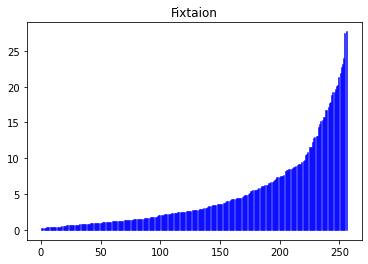

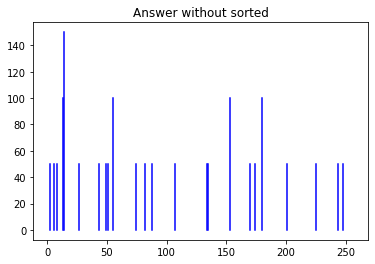

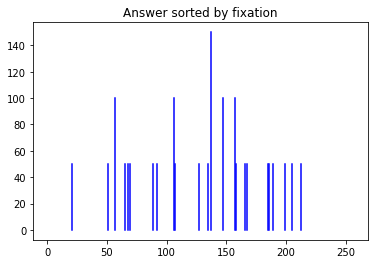

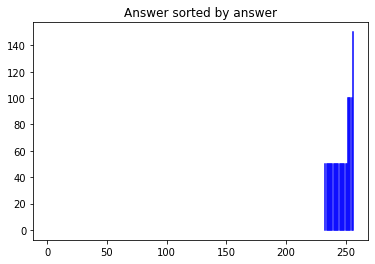

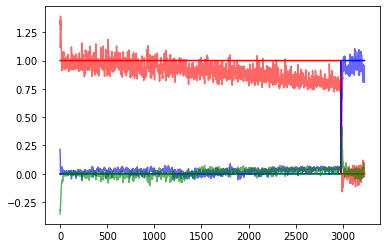

In [30]:
from norse.torch import LIFAdExState
Task_test = MultyReduceTasks(
    tasks=task_dict,
    batch_size=batch_size,
    delay_between=0,
    enable_fixation_delay=True,
    mode="random",
    task_number=6
)
batch_size=20
def check_mean_fr(task = Task):
    init_state = LIFAdExState(
            torch.zeros(batch_size, hidden_size).to(device),
            torch.rand(batch_size, hidden_size).to(device),
            torch.zeros(batch_size, hidden_size).to(device),
            torch.zeros(batch_size, hidden_size).to(device),
        )
    inputs, target_outputs = task.dataset(1)

    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
    result = model(inputs, init_state,)
    #del inputs, init_state
    torch.cuda.empty_cache()
    states = result[-1]
    spikes = []
    for state in states:
        spikes.append(state.detach().cpu())

    last_fix = torch.where(inputs[:, :, 0] == 1)[0][-1].item()
    s = torch.stack(spikes)[:last_fix, ...]
    #s = torch.stack(spikes)[:, ...]
    freq_sequence_new = torch.sort(
        torch.mean(torch.mean(s, axis=0), axis=0), dim=0
    )
    indexes_for_sort = freq_sequence_new.indices
    freq_sequence_new = freq_sequence_new.values
    for i in range(len(freq_sequence_new)):
        plt.plot([i + 1] * 2, [0, freq_sequence_new[i] * 1e3], c="b")
    plt.title('Fixtaion')
    plt.show()
    plt.close()
    
    last_fix = torch.where(inputs[:, :, 0] == 1)[0][-1].item()
    s = torch.stack(spikes)[last_fix:, ...]
    #s = torch.stack(spikes)[:, ...]
    freq_sequence = (
        torch.mean(torch.mean(s, axis=0), axis=0))
    freq_sequence_new = torch.zeros_like(freq_sequence)
    for i in range(len(freq_sequence_new)):
        plt.plot([i + 1] * 2, [0, freq_sequence[i] * 1e3], c="b")
    plt.title('Answer without sorted')
    plt.show()
    plt.close()
    for i in range(len(freq_sequence)):
        freq_sequence_new[i] = freq_sequence[indexes_for_sort[i]]
    for i in range(len(freq_sequence_new)):
        plt.plot([i + 1] * 2, [0, freq_sequence_new[i] * 1e3], c="b")
    plt.title('Answer sorted by fixation')
    plt.show()
    plt.close()
    
    freq_sequence_new = torch.sort(freq_sequence_new).values
    for i in range(len(freq_sequence_new)):
        plt.plot([i + 1] * 2, [0, freq_sequence_new[i] * 1e3], c="b")
    plt.title('Answer sorted by answer')
    plt.show()
    plt.close()
    index=0
    plt.plot(target_outputs[:, index, 0].detach().cpu(), c='r')
    plt.plot(target_outputs[:, index, 1].detach().cpu(), c='b')
    plt.plot(target_outputs[:, index, 2].detach().cpu(), c='g')

    plt.plot(result[0][:, index, 0].detach().cpu(), c='r', alpha=.6
            )
    plt.plot(result[0][:, index, 1].detach().cpu(), c='b', alpha=.6
            )
    plt.plot(result[0][:, index, 2].detach().cpu(), c='g', alpha=.6
        )
    plt.show()
    plt.close()
Task.batch_size = 20
check_mean_fr(Task)

0


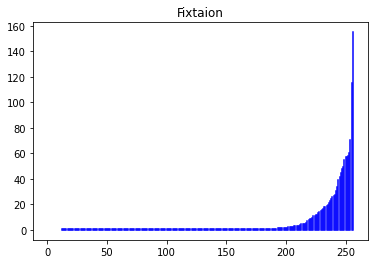

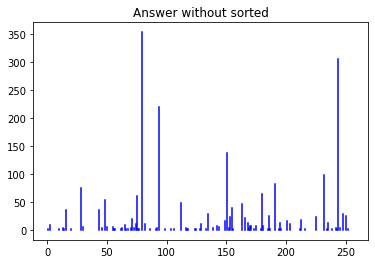

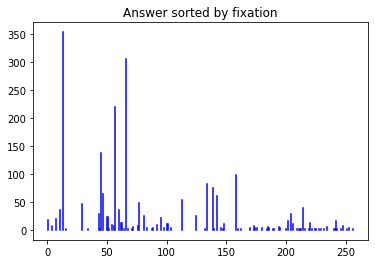

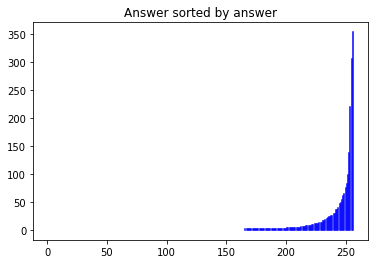

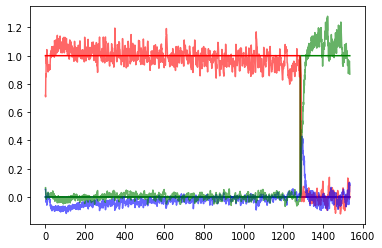

1


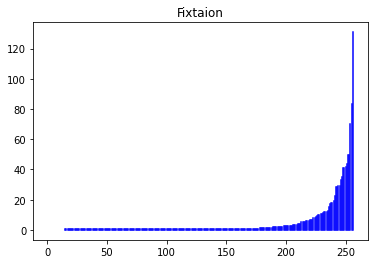

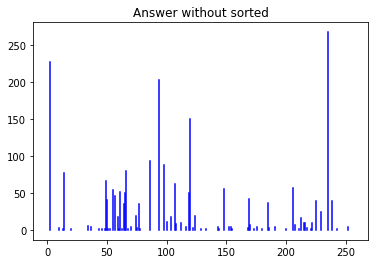

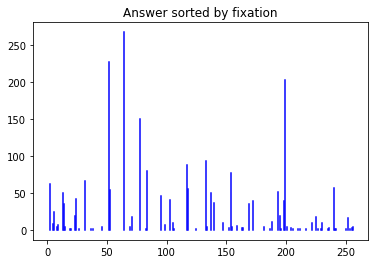

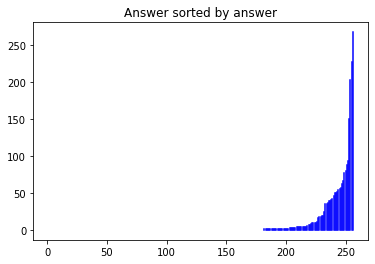

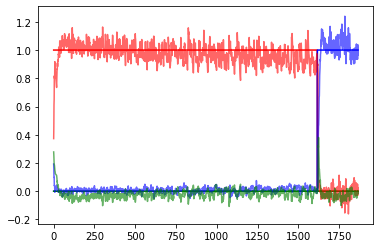

2


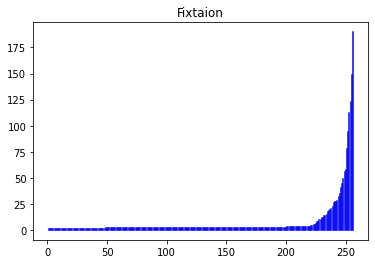

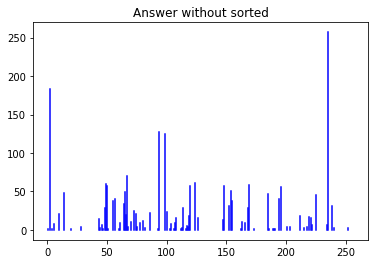

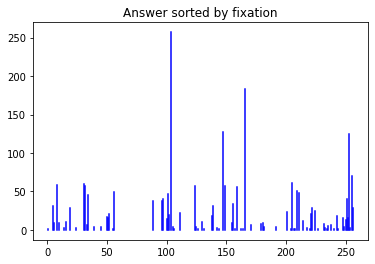

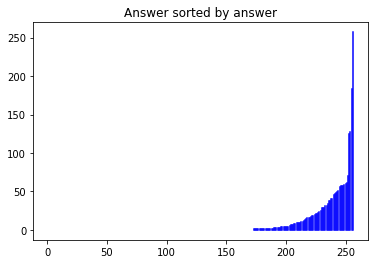

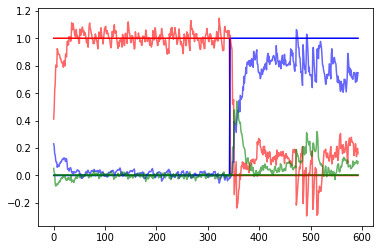

3


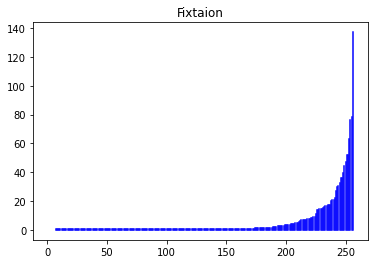

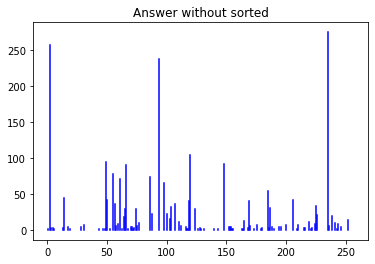

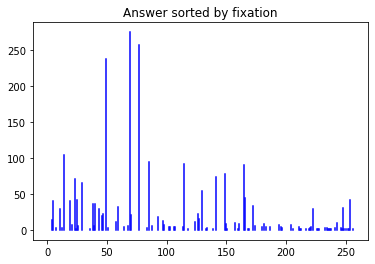

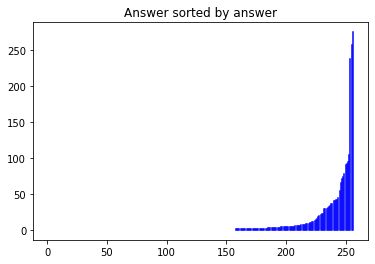

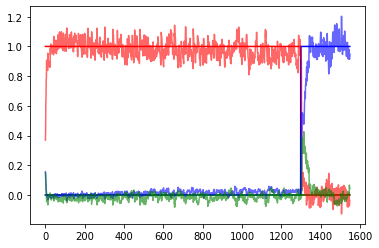

4


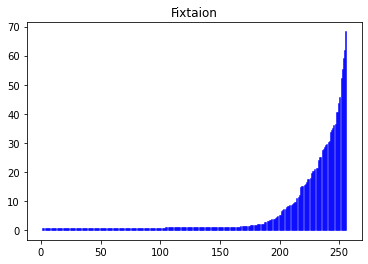

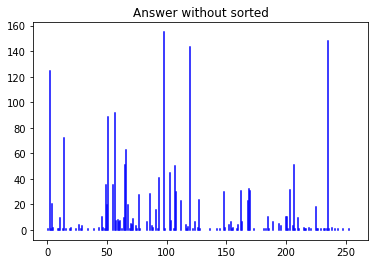

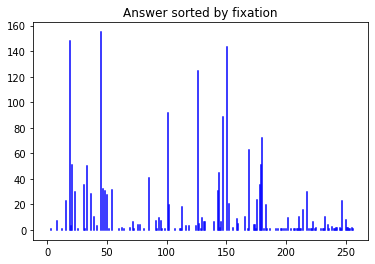

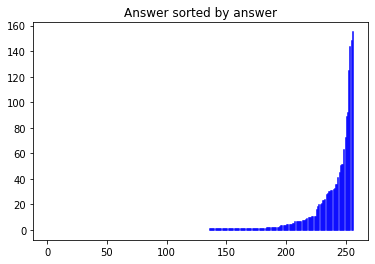

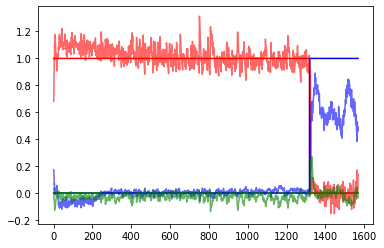

5


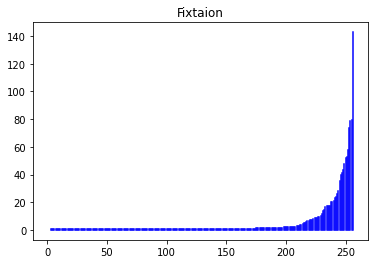

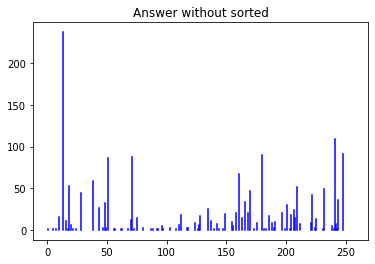

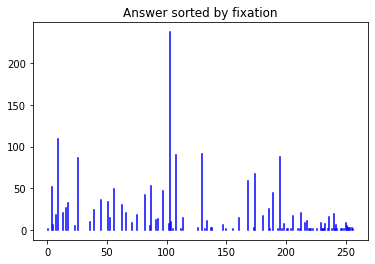

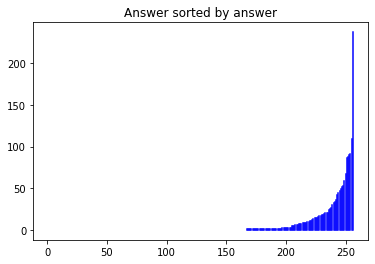

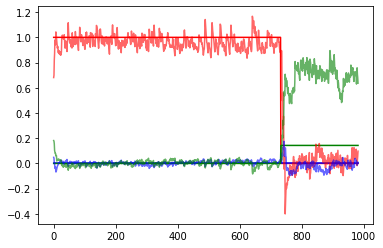

6


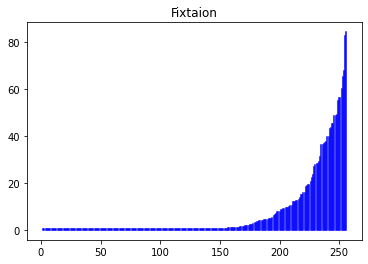

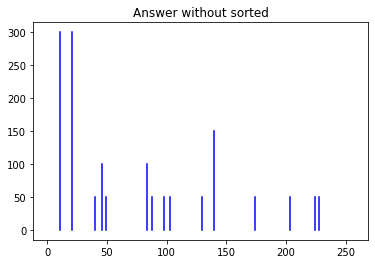

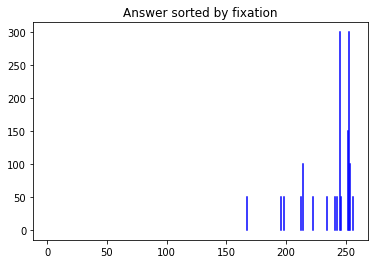

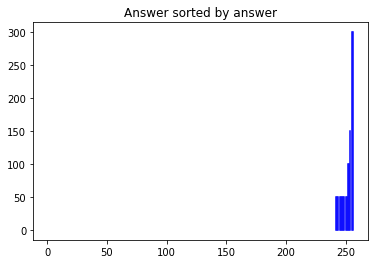

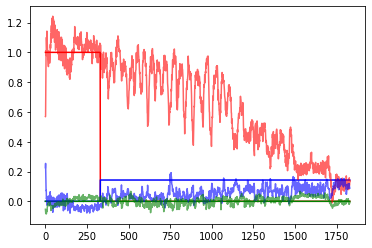

7


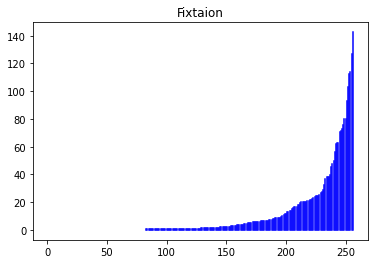

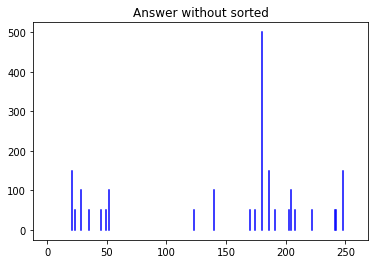

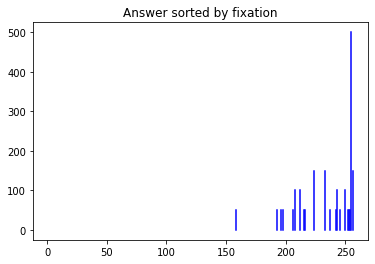

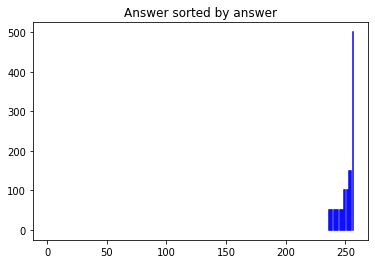

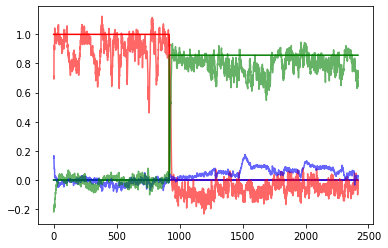

8


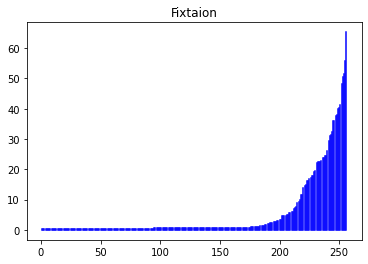

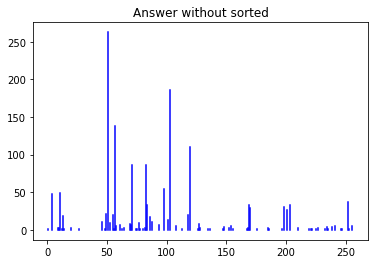

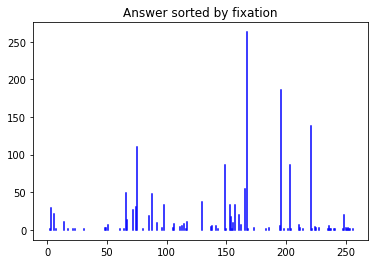

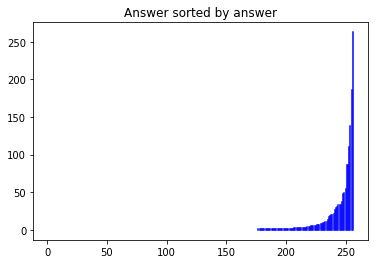

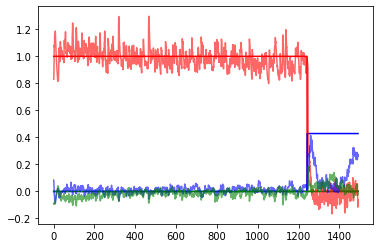

9


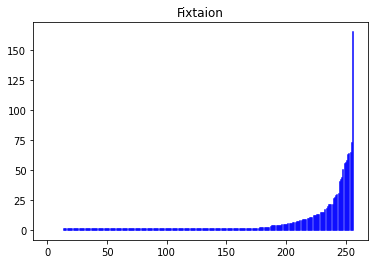

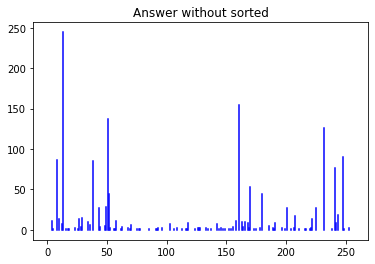

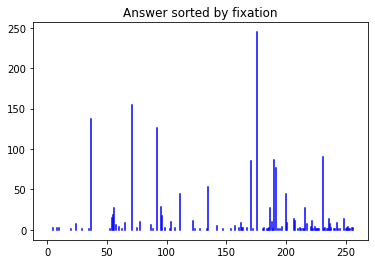

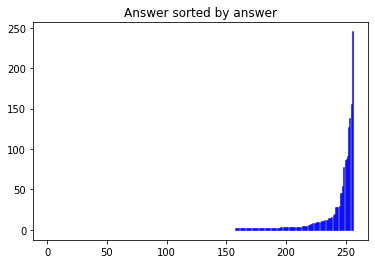

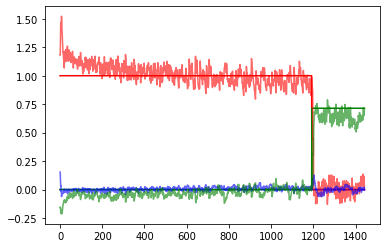

10


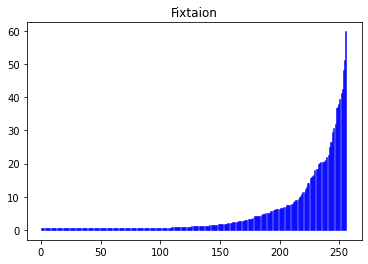

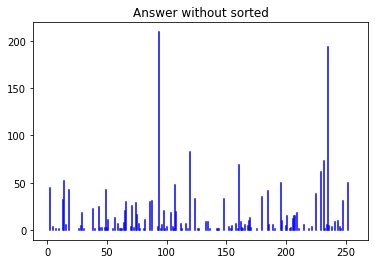

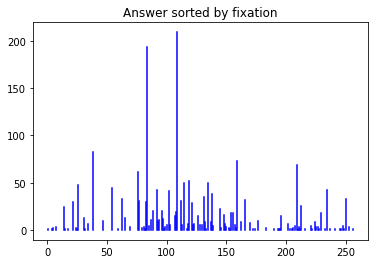

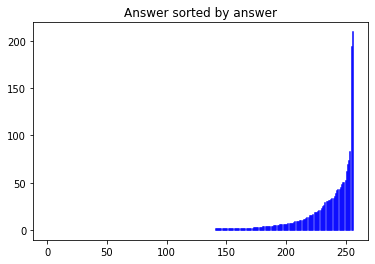

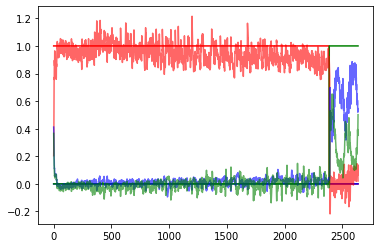

11


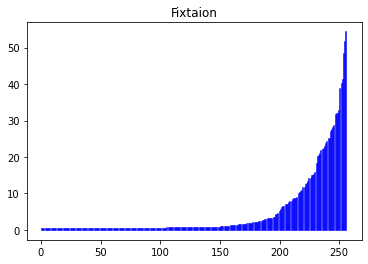

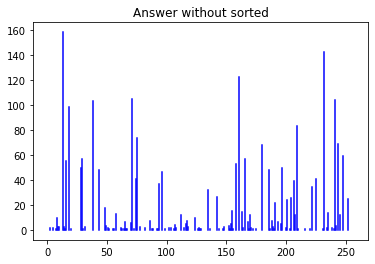

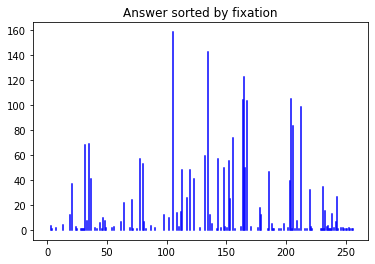

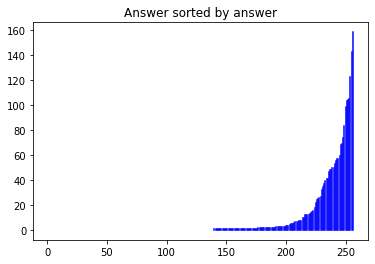

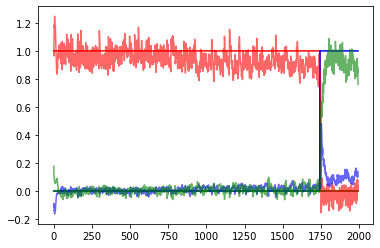

In [33]:

for i in range(len(tasks)):
    test = MultyReduceTasks(
        tasks=task_dict,
        batch_size=1,
        delay_between=0,
        enable_fixation_delay=True,
        mode="random",
        task_number=i
    )
    print(i)
    check_mean_fr(test)

# Основной цикл обучения

In [ ]:
model.save_states = True
sorted_tasks = sorted(tasks)
re_word = "Go"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAXcAAAEICAYAAACktLTqAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAAXBUlEQVR4nO3de7BsZX3m8e8jNy1UUDiSIxcPKjNKmRLJUUmiYsk4IlExiRcSI2iRMNbojFTMKJpxgjXORGdGURzLDAYDXuJdSlSmRiKCmih6MAcUiOGgIBy5HBBQvBCR3/yx3q3Ndl/P7r1773d/P1Vde631rl7rfXt1P+vtd3X3TlUhSerLfSZdAUnS+BnuktQhw12SOmS4S1KHDHdJ6pDhLkkdMtylnZTk1CTvn6XsqUmuH9N+7pfkU0nuSPLRJC9K8tlxbHuGff1Vktcvx7a1snaddAU0GUkuBB4L/FpV3TXh6kxEkmuAP66qv5t0XebxPGA/YJ+qurst+8BSN5rkJQztf9LUsqp62VK3q9XBnvs6lGQT8GSggOdMtjazS7IsnY/l2u4yehjwzyPBLs3LcF+fjge+ApwFnDBakOSsJO9M8pkkP0xycZJHtLIkOS3JzUl+kOQbSR6T5OAktye5T1vv3UluHtnm+5Kc3Kb3SnJmkhuSbE/yxiS7tLKXJPn7to9bgVOnVzzJE5Jsafu/KclbR8qek+TyVpcLkzx6pOyaJK9JchnwoyQfBA4CPpXkziSvbusdkeQf2jYuTfLUkW0cnOSi9ricD+w73wOd5HVJbmn7f1Fb9vhW911G1vu9JJfOcP83AP8FeGGr54ntcfpSK/+ttv0D2/xjk9yW5FFt/pQkV7c6X5Hkd9vyRwN/Bfxm2+7tI8f/jSP7/5Mk25J8P8m5SR46UlZJXpbkqvZ4vTNJ5ntMtEKqyts6uwHbgH8P/AbwM2C/kbKzgFuBJzAM230A+FArewZwCbA3EODRwMZW9l3gN9r0t4BvA48eKXtcmz4H+D/AnsBDgK8C/66VvQS4G/gPbd/3m6HuXwZe3KbvDxzRpv8V8CPg6cBuwKtbO3dv5dcAW4EDp7bblv2bkW3v39p+DEPH5+ltfsPIvt8K7AE8Bfgh8P5ZHuOntrZMrX9kq9+/buVXAM8cWf8c4FWzbOvU0f20x+lLI/P/DbgAuB/wDeAVI2XPBx7a2vPCVoeNM21n5Pi/sU0/DbgFOLy14R3AF0bWLeDT7flwELADOHrSz29vw82e+zqT5EkMb/M/UlWXAFcDfzhttXOq6qs1DAN8ADisLf8Z8ADgUUCq6sqquqGVXQQcmeTX2vzH2vzBwAOBS5PsxxCcJ1fVj6rqZuA04LiRfX+vqt5RVXdX1U9maMLPgEcm2beq7qyqr7TlLwQ+U1XnV9XPgP/FEHa/NXLf06vqulm2C/BHwHlVdV5V3VNV5wNbgGOSHAQ8Hnh9Vd1VVV8APjXLdkZNrX8R8BngBW352W1/JHkww4nzbxewvZmcCuzFcKLcDrxzqqCqPlpV32vt+TBwFcOJeyFeBLynqr5ew3WZ1zL09DeNrPOmqrq9qr4LfJ5fPlc0YYb7+nMC8NmquqXN/y3ThmaAG0emf8zQQ6aqLgD+N0N43JzkjCQPbOtdxNBbfQrwBeBCht7qkcAXq+oehpPKbsAN7W387Qy9+IeM7O+6eep/IkMv/Z+SfC3Js9ryhwLXTq3U9ncdQ298odt+GPD8qbq1+j0J2Ni2f1tV/Whk/Wtn2MaomdafGtZ4P/DsJHsyBP4XR06Ui9JOZmcBjwHeUlW/+DXAJMcn2TrSnsewgOGkZvpjeifDO5nRx3TG54omb61dWNISJLkfQ5DskmTqRbkHsHeSx1bVr4z5TldVpwOnJ3kI8BHgPwGvZwj3/wlc36a/xDCm+9M2D0O43gXsW7NfHJzzZ0qr6irgD9r4/u8BH0uyD/A94NdH2hqGIZjtc2x7+vx1wPuq6k+m7zfJw4AHJdlzJLAPmqe+M63/zdaO7Um+3NrwYuBdc2xnTkn2B/4C+BvgLUkeX1V3tTq/GzgK+HJV/TzJVoYhNeapOwyP6cNG9rMnsA/3fky1StlzX1+eC/wcOJTh7fNhDOPmX2S4yDqndiHwiUl2Yxi7/SlwD/widH/CMNRwUVX9ALgJ+H1auLee6WcZAuiBSe6T5BFJjlxoA5L8UZINrWd+e1t8D8OJ5neSHNXq9yqGE8k/zLG5m4CHj8xP9aafkWSXJPfN8Hn1A6rqWoYhmjck2b0Nbz17AVWeWv/JwLOAj46UvZfh2sCvA59YwLZ+RTuJnQWcyfCu5gbgv7biPRkCfEdb96UMPfcpNwEHJNl9ls1/EHhpksOS7AH8d+DiqrpmZ+qqlWW4ry8nAH9TVd+tqhunbgxDLS/K/B8RfCBDT/A2hrfrtzL01qdcBNxaVdeNzAf4+sg6xwO7M1xQvI1hbH7jItpwNHB5kjuBtwPHVdVPqupbDCeWdzBcBHw28Oyq+pc5tvWXwH9uQxZ/1up9LPA6hkC8juGdydTr5A+BJwLfZ+gpv3eeut7Y2vg9hmsXL6uqfxopP4ehZ3xOVf14Qa3/Vf+RYVjr9W045qUMgfzkqroCeAvDheCbGE4ifz9y3wuAy4Ebk9zCNDV8/v/1wMcZThqP4N7XR7SKZWR4TtIKS3I1w6eFVvsXqbTG2HOXJiTJ7zMMm1ww6bqoP15QlSYgw88/HMrwmf17JlwddchhGUnqkMMyktShVTEss++++9amTZsmXQ1JWlMuueSSW6pqw0xlqyLcN23axJYtWyZdDUlaU5LM+i1ph2UkqUOGuyR1yHCXpA4Z7pLUIcNdkjpkuEtShwx3SeqQ4a6xOPnk4SZpdVgVX2LS2rd166RrIGmUPXdJ6pDhLkkdMtwlqUOGuyR1yHCXpA4Z7pLUIcNdkjpkuEtShwx3SeqQ4S5JHTLcJalDhrskdchwl6QOGe6S1CHDXZI6ZLhLUocMd0nqkOEuSR0y3CWpQ4a7JHXIcJekDhnuktShBYd7kl2S/GOST7f5g5NcnGRbkg8n2b0t36PNb2vlm5ap7pKkWSym5/5K4MqR+TcDp1XVI4HbgBPb8hOB29ry09p6kqQVtKBwT3IA8DvAX7f5AE8DPtZWORt4bps+ts3Tyo9q60uSVshCe+5vA14N3NPm9wFur6q72/z1wP5ten/gOoBWfkdb/16SnJRkS5ItO3bs2LnaS5JmNG+4J3kWcHNVXTLOHVfVGVW1uao2b9iwYZyblqR1b9cFrPPbwHOSHAPcF3gg8HZg7yS7tt75AcD2tv524EDg+iS7AnsBt4695pKkWc3bc6+q11bVAVW1CTgOuKCqXgR8HnheW+0E4JNt+tw2Tyu/oKpqrLWWJM1pKZ9zfw3wp0m2MYypn9mWnwns05b/KXDK0qooSVqshQzL/EJVXQhc2Ka/DTxhhnV+Cjx/DHWTJO0kv6EqSR0y3CWpQ4a7JHXIcJekDhnuktQhw12SOmS4S1KHDHdJ6pDhLkkdMtwlqUOGuyR1yHCXpA4Z7pLUIcNdkjpkuEtShwx3SeqQ4S5JHTLcJalDhrskdchwl6QOGe6S1CHDXZI6ZLhLUocMd0nqkOEuSR0y3CWpQ4a7JHXIcJekDhnuktQhw12SOmS4S1KHDHdJ6pDhLkkdMtwlqUPzhnuS+yb5apJLk1ye5A1t+cFJLk6yLcmHk+zelu/R5re18k3L3AZJ0jQL6bnfBTytqh4LHAYcneQI4M3AaVX1SOA24MS2/onAbW35aW09SdIKmjfca3Bnm92t3Qp4GvCxtvxs4Llt+tg2Tys/KknGVWFJ0vwWNOaeZJckW4GbgfOBq4Hbq+rutsr1wP5ten/gOoBWfgewzwzbPCnJliRbduzYsaRGSJLubUHhXlU/r6rDgAOAJwCPWuqOq+qMqtpcVZs3bNiw1M1JkkYs6tMyVXU78HngN4G9k+zaig4Atrfp7cCBAK18L+DWcVRWkrQwC/m0zIYke7fp+wFPB65kCPnntdVOAD7Zps9t87TyC6qqxlhnSdI8dp1/FTYCZyfZheFk8JGq+nSSK4APJXkj8I/AmW39M4H3JdkGfB84bhnqLUmaw7zhXlWXAY+bYfm3Gcbfpy//KfD8sdROkrRT/IaqJHXIcJekDhnuktQhw12SOmS4S1KHDHdJ6pDhLkkdMtwlqUOGuyR1yHCXpA4Z7pLUIcNdkjpkuEtShwx3SeqQ4S5JHTLcJalDhrskdchwl6QOGe6S1CHDXZI6ZLhLUocMd0nqkOEuSR0y3CWpQ4a7JHXIcJekDhnuWpSTTx5ukla3XSddAa0tW7dOugaSFsKeuyR1yHCXpA4Z7pLUIcNdkjpkuEtShwx3SerQvOGe5MAkn09yRZLLk7yyLX9wkvOTXNX+PqgtT5LTk2xLclmSw5e7EZKke1tIz/1u4FVVdShwBPDyJIcCpwCfq6pDgM+1eYBnAoe020nAu8Zea0kL4pfO1q95v8RUVTcAN7TpHya5EtgfOBZ4alvtbOBC4DVt+XurqoCvJNk7yca2HUkryC+drV+LGnNPsgl4HHAxsN9IYN8I7Nem9weuG7nb9W3Z9G2dlGRLki07duxYbL0lSXNYcLgnuT/wceDkqvrBaFnrpddidlxVZ1TV5qravGHDhsXcVZI0jwWFe5LdGIL9A1X1ibb4piQbW/lG4Oa2fDtw4MjdD2jLJEkrZCGflglwJnBlVb11pOhc4IQ2fQLwyZHlx7dPzRwB3OF4uyStrIX8KuRvAy8GvpFka1v2OuBNwEeSnAhcC7yglZ0HHANsA34MvHScFZYkzW8hn5b5EpBZio+aYf0CXr7EekmSlsBvqEpShwx3SeqQ4S5JHTLcJalDhrskdchwl6QOGe6S1CHDXZI6ZLhLUocMd0nqkOHeCf/jjqRRC/nhMK0B/scdSaPsuUtShwx3zcnhHmltclhGc3K4R1qb7LlLUocMd0nqkOE+Ro5PS1otHHMfI8enJa0W9twlqUOGuyR1yHCXpA4Z7pLUIcNdkjpkuEtShwx3SeqQ4S5JHTLcJalDhrskdWjdh7u/ByOpR+v+t2X8PRhJPVr3PXdJ6pHhLkkdMtwlqUPzhnuS9yS5Ock3R5Y9OMn5Sa5qfx/UlifJ6Um2JbksyeHLWXlJ0swW0nM/Czh62rJTgM9V1SHA59o8wDOBQ9rtJOBd46mmJGkx5g33qvoC8P1pi48Fzm7TZwPPHVn+3hp8Bdg7ycYx1VWStEA7O+a+X1Xd0KZvBPZr0/sD142sd31b9iuSnJRkS5ItO3bs2MlqSJJmsuQLqlVVQO3E/c6oqs1VtXnDhg1LrYYkacTOhvtNU8Mt7e/Nbfl24MCR9Q5oy7RG+I1dqQ87G+7nAie06ROAT44sP759auYI4I6R4RutAVu39v+tXU9gWg/m/fmBJB8Engrsm+R64C+ANwEfSXIicC3wgrb6ecAxwDbgx8BLl6HOGoOpcHvb2yZZi8no/eQlwQLCvar+YJaio2ZYt4CXL7VSS7GeQ2sxDDipb939cJihJUn+/IDWIMfMpfl113NX/3p8d+ZwosbNcJdWgR5PWJosh2WkCTv5ZNi2bdK1UG8M90VyvFcLsZjnydatcOedy1gZrUsOyyySb5+1ED5PNGn23LVTfAcjrW723LVT7JlKq1s34W4vUpJ+qZtwtycpSb/kmLskdchwX0O8iClpoboZllkPHHq6N7+yL83OcNea5cluZXkyXVsMd0kL4sl0bXHMXVqlvMaipbDnLq1S9pS1FPbcJalDhru0Rq22YZvVVp/1zmEZaY1abcM2q60+6509d0nqkOGuVcu3+euHx3r8HJbRquXb/KWZ+vd9j3zkpGsyP4/1+Nlzl1aRcfZg/fd965s9d2kVsQfbt5X8CQd77tIqtm3bZMaiHQNfHlu3rtwJ3HDXsjEglu7OOyfTm1/JEJoyqRPZqJ6esw7LaNlMeojBXzFcWyZ1Ihs16f2Pk+E+YQbQ8unphSotluE+YQbQ+Hii1Go1iaEew13d6OlEOfUZdfVhEs9NL6iOiS9GLcRCL9j5GXUt1boK9+W8Ej7bi3E1X31fDZ9OWO3GffxGP4Uyrm2Pu47roaMyydflSr3ulmVYJsnRwNuBXYC/rqo3Lcd+Fmv0rdH0B3e5xmsnPVQwV7tWw6cTFmqhx2fqhTOu4zgaxAvZ/85seyW2s5j6T++o9NgBmOTzfqVed2MP9yS7AO8Eng5cD3wtyblVdcW49zWbuV7gU2XTH9zlfrCnv7hme8HM9CJcyotrpnbN1jNb6d8iWWzgzLcdWL4Xzji2uVKP70zPl6XUf5JBuJjnyPR2T7/PaPnocZhrH7Ntc756nXwyXHQRHHnk3Dm0nBf/l6Pn/gRgW1V9GyDJh4BjgRUL97le4JP8Ushc83MtH3d9ZxtCWulx3pXsua4GK/X4rpXHYyEW05b51h0tHz0Oc91vMa/T6eXf+Q7stdfM5SuRQ8sR7vsD143MXw88cfpKSU4CTgI46KCDlrzTww775fQdd9x7fnSd2cp2Zj8L2fZc6y90+ULqu9jt3XHHr5bP1IaltGe+ei+mfK46jRqt/2If+6WuO9/9pj++8z1nZzpGC6nbQl4Lc5mrnvPdb2ct9vWzM/uf7XEZ1/N9evlcx3oh21iqVNV4N5g8Dzi6qv64zb8YeGJVvWK2+2zevLm2bNky1npIUu+SXFJVm2cqW45Py2wHDhyZP6AtkyStkOUI968BhyQ5OMnuwHHAucuwH0nSLMY+5l5Vdyd5BfD/GD4K+Z6qunzc+5EkzW5ZPudeVecB5y3HtiVJ81tX31CVpPXCcJekDhnuktQhw12SOjT2LzHtVCWSHcC1O3HXfYFbxlyd1Ww9tXc9tRVsb8+Ws60Pq6oNMxWsinDfWUm2zPbtrB6tp/aup7aC7e3ZpNrqsIwkdchwl6QOrfVwP2PSFVhh66m966mtYHt7NpG2rukxd0nSzNZ6z12SNAPDXZI6tGbDPcnRSb6VZFuSUyZdn3FLck2SbyTZmmRLW/bgJOcnuar9fdCk67mzkrwnyc1JvjmybMb2ZXB6O9aXJTl8cjXfObO099Qk29sx3prkmJGy17b2fivJMyZT652T5MAkn09yRZLLk7yyLe/y+M7R3ske36paczeGnxK+Gng4sDtwKXDopOs15jZeA+w7bdn/AE5p06cAb550PZfQvqcAhwPfnK99wDHA/wUCHAFcPOn6j6m9pwJ/NsO6h7bn9B7Awe25vsuk27CItm4EDm/TDwD+ubWpy+M7R3snenzXas/9F/+Eu6r+BZj6J9y9OxY4u02fDTx3clVZmqr6AvD9aYtna9+xwHtr8BVg7yQbV6SiYzJLe2dzLPChqrqrqr4DbGN4zq8JVXVDVX29Tf8QuJLhfyt3eXznaO9sVuT4rtVwn+mfcM/1YK5FBXw2ySXtn4kD7FdVN7TpG4H9JlO1ZTNb+3o+3q9oQxHvGRlm66a9STYBjwMuZh0c32nthQke37Ua7uvBk6rqcOCZwMuTPGW0sIb3d91+jrX39jXvAh4BHAbcALxlorUZsyT3Bz4OnFxVPxgt6/H4ztDeiR7ftRru3f8T7qra3v7eDJzD8Lbtpqm3q+3vzZOr4bKYrX1dHu+quqmqfl5V9wDv5pdvzdd8e5PsxhB0H6iqT7TF3R7fmdo76eO7VsO963/CnWTPJA+Ymgb+LfBNhjae0FY7AfjkZGq4bGZr37nA8e1TFUcAd4y8vV+zpo0r/y7DMYahvccl2SPJwcAhwFdXun47K0mAM4Erq+qtI0VdHt/Z2jvx4zvpK81LuEJ9DMNV6auBP590fcbctoczXE2/FLh8qn3APsDngKuAvwMePOm6LqGNH2R4q/ozhjHHE2drH8OnKN7ZjvU3gM2Trv+Y2vu+1p7L2gt+48j6f97a+y3gmZOu/yLb+iSGIZfLgK3tdkyvx3eO9k70+PrzA5LUobU6LCNJmoPhLkkdMtwlqUOGuyR1yHCXpA4Z7pLUIcNdkjr0/wGrK8FI5arREAAAAABJRU5ErkJggg==
choices_tasks = []
values_tasks = []
for i in range(len(sorted_tasks)):
    if re_word in sorted_tasks[i]:
        values_tasks.append(i)
    else:
        choices_tasks.append(i)
can = CorrectAnswerNetwork(choices_tasks, values_tasks, 0.15)
inputs, target_outputs = Task.dataset(1, delay_between=0)
inputs[:, :, 1:3] += every_bath_generator(0, 0.01, inputs.shape[0], inputs.shape[1], 2)
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
outputs, states = model(
    inputs,
    init_state,
    additional_current=additional_current_generate(
        len(inputs),
        batch_size,
        hidden_size,
    ).to(device),
)
type_tasks = list(np.where(inputs[-1, :, 3:].detach().cpu().numpy() == 1)[1])
answers = can.run(
    target_outputs[:, :, 0].cpu(),
    outputs[:, :, 0].cpu(),
    target_outputs[:, :, 1:].cpu(),
    outputs[:, :, 1:].cpu(),
    type_tasks,
)
result += answers

In [ ]:
inputs, target_outputs = Task.dataset(1, delay_between=0)
inputs = torch.from_numpy(inputs).type(torch.float).to(device)# * 0
target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
init_state = LIFAdExState(
        torch.zeros(batch_size, hidden_size).to(device),
        torch.rand(batch_size, hidden_size).to(device),
        torch.zeros(batch_size, hidden_size).to(device),
        torch.zeros(batch_size, hidden_size).to(device),
    )
outputs, states, _ = model(
    inputs,
    init_state,
        
    )
task_number = sorted_tasks.index('RomoTask1')

outputs = outputs.cpu().detach()
target_outputs = target_outputs.detach().cpu()
s = []
for i in range(len(states)):
    s.append(states[i].z)
s = torch.stack(s).detach().cpu()

plt.plot(target_outputs[:, task_number, 0].cpu())
plt.plot(outputs[:, task_number, 0].detach().cpu())
plt.show()
plt.close()
plt.plot(target_outputs[:, task_number, 1].cpu())
plt.plot(outputs[:, task_number, 1].detach().cpu())
plt.show()
plt.close()
plt.plot(target_outputs[:, task_number, 2].cpu())
plt.plot(outputs[:, task_number, 2].detach().cpu())
plt.show()
plt.close()
plt.figure(figsize=(20, 10))
plt.imshow(s[:, task_number, :].T, aspect="auto", interpolation="nearest")

In [ ]:
for_sort = torch.sort(torch.mean(torch.mean(s, axis=0), axis=0), dim=0
).indices
s_new = torch.zeros_like(s)
for i in range(hidden_size):
    s_new[:, :, i] = s[:, :, for_sort[i]]
plt.imshow(s_new[:, task_number, :].T, aspect="auto", interpolation="nearest", origin='lower',)

In [ ]:
# spike_sequence = torch.stack(spike_sequence)
freq_sequence = torch.mean(torch.mean(spike_sequence, axis=0), axis=0)

# freq_sequence = sort_elemnts_by_another (freq_sequence, freq_sequence)
print(f"{spike_sequence.shape=}")
print(f"{freq_sequence.shape=}")
for i in range(len(freq_sequence)):
    plt.plot([i + 1] * 2, [0, freq_sequence[i]], c="b")
plt.show()
plt.close()
model.save_states = False

In [ ]:
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

frequency = torch.mean(torch.mean(s, axis=0), axis=0) * 1e3
frequency = sort_elemnts_by_another(freq_sequence, frequency)
for i in range(len(frequency)):
    plt.plot([i + 1] * 2, [0, frequency[i]], c="b")

In [ ]:
result

In [ ]:
list(np.where(inputs[-1, :, 3:].detach().cpu().numpy() == 1)[1])

# Тестовая функция

In [ ]:
def test_network(
        test_sigma: float, number_of_trials: int = 100, plot_data: bool = True
):
    result = 0
    for j in tqdm(range(number_of_trials)):
        try:
            del inputs
        except:
            pass
        try:
            del target_outputs
        except:
            pass
        try:
            del outputs
        except:
            pass
        torch.cuda.empty_cache()
        inputs, target_outputs = Task.dataset(1, delay_between=0)
        inputs[:, :, :3] += every_bath_generator(
            0, test_sigma, inputs.shape[0], inputs.shape[1], 3
        )
        inputs = torch.from_numpy(inputs).type(torch.float).to(device)
        target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
        outputs = model(inputs)[0]
        answers = correct_answer(
            outputs[:, :, 1:], target_outputs[:, :, 1:], target_outputs[:, :, 0]
        )
        result += torch.sum(answers).item()

    accuracy = result / batch_size / number_of_trials * 100
    if plot_data:
        plot_results(inputs, target_outputs, outputs)
    try:
        del inputs
    except:
        pass
    try:
        del target_outputs
    except:
        pass
    try:
        del outputs
    except:
        pass
    torch.cuda.empty_cache()
    return accuracy

# Тестирование
```  np.random.normal(0, 0.01, size=(inputs.shape)) ```

In [ ]:
accuracy = test_network(0.01, 1)
print(accuracy)

# Тестирование
```  np.random.normal(0, 0.05, size=(inputs.shape)) ```

In [ ]:
accuracy = test_network(0.05, 10)
print(accuracy)

# Тестирование
```  np.random.normal(0, 0.1, size=(inputs.shape)) ```

In [ ]:
accuracy = test_network(0.1)
print(accuracy)

# Тестирование
```  np.random.normal(0, 0.5, size=(inputs.shape)) ```

In [ ]:
accuracy = test_network(0.5)
print(accuracy)

In [ ]:
result = 0
for j in tqdm(range(1)):
    try:
        del inputs
    except:
        pass
    try:
        del target_outputs
    except:
        pass
    try:
        del outputs
    except:
        pass
    torch.cuda.empty_cache()
    inputs, target_outputs = Task.dataset(1, delay_between=0)
    inputs[:, :, :3] += np.random.normal(0, 0.5, size=inputs[:, :, :3].shape)
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
    outputs = model(inputs)[0]
    answers = correct_answer(
        outputs[:, :, 1:], target_outputs[:, :, 1:], target_outputs[:, :, 0]
    )
    result += torch.sum(answers).item()

accuracy = result / batch_size / 100 * 100
print(accuracy)
plot_results(inputs, target_outputs, outputs)
try:
    del inputs
except:
    pass
try:
    del target_outputs
except:
    pass
try:
    del outputs
except:
    pass
torch.cuda.empty_cache()

In [ ]:
result = 0
for j in tqdm(range(1)):
    try:
        del inputs
    except:
        pass
    try:
        del target_outputs
    except:
        pass
    try:
        del outputs
    except:
        pass
    torch.cuda.empty_cache()
    inputs, target_outputs = Task.dataset(1, delay_between=0)
    inputs[:, :, :3] += np.random.normal(0, 0.7, size=inputs[:, :, :3].shape)
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
    outputs = model(inputs)[0]
    answers = correct_answer(
        outputs[:, :, 1:], target_outputs[:, :, 1:], target_outputs[:, :, 0]
    )
    result += torch.sum(answers).item()

accuracy = result / batch_size / 100 * 100
print(accuracy)
plot_results(inputs, target_outputs, outputs)
try:
    del inputs
except:
    pass
try:
    del target_outputs
except:
    pass
try:
    del outputs
except:
    pass
torch.cuda.empty_cache()

In [ ]:
inputs = 0
outputs = 0

In [ ]:
lines = []
with open("accuracy_multy.txt", "r") as f:
    while line := f.readline():
        lines.append(float(line.split("=")[2]))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot([*range(9, 3000, 50)], lines, ".", linestyle="--", markersize=5)
plt.ylabel(r"Accuracy%")
plt.xlabel(r"Epochs")

In [ ]:
start_sigma = 0
stop_sigma = 2
step_sigma = 0.05
sigma_array = np.arange(start_sigma, stop_sigma, step_sigma)
for test_sigma in tqdm(sigma_array):
    result = 0
    for j in range(20):
        try:
            del inputs
        except:
            pass
        try:
            del target_outputs
        except:
            pass
        try:
            del outputs
        except:
            pass
        torch.cuda.empty_cache()
        inputs, target_outputs = Task.dataset(1, delay_between=0)
        inputs[:, :, 1:3] += np.random.normal(
            0, test_sigma, size=inputs[:, :, 1:3].shape
        )
        inputs = torch.from_numpy(inputs).type(torch.float).to(device)
        target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
        outputs = model(inputs)[0]
        type_tasks = list(np.where(inputs[-1, :, 3:].detach().cpu().numpy() == 1)[1])
        answers = can.run(
            target_outputs[50:, :, 0].cpu(),
            outputs[50:, :, 0].cpu(),
            target_outputs[50:, :, 1:].cpu(),
            outputs[50:, :, 1:].cpu(),
            type_tasks,
        )
        result += answers
    accuracy = result / batch_size / 20 * 100
    with open("accuracy_vs_noise.txt", "a") as f:
        f.write(f"noise={test_sigma}:accuracy={accuracy}\n")

In [ ]:
import matplotlib.patches as patches

plt.style.use("ggplot")


def parser(line_text: str) -> tuple:
    """
    Function parses text in form:
    ```v_name_1=v1:v_name_2:v2```
    and return (v1, v2)
    :param line_text:
    :return: (v1, v2)
    """
    line_text = line_text.split(":")
    print(line_text)
    v1 = line_text[0].split("=")[1]
    v2 = line_text[1].split("=")[1]
    return float(v1), float(v2)


x, y = [], []
# with open('accuracy_vs_noise.txt', 'r') as f:
with open(
        r"accuracy_vs_noise.txt",
        "r",
) as f:
    while line := f.readline():
        t_x, t_y = parser(line)
        x.append(t_x)
        y.append(t_y)

fig, ax = plt.subplots()
ax.plot(x, y, ".", linestyle="--")
# ax.plot([.5]*2, [50, 100])
ax.set_ylabel("Accuracy,%")
ax.set_xlabel(r"$\sigma$")
ax.add_patch(
    patches.Rectangle(
        (0, 50), 0.5, 50, edgecolor="grey", facecolor="grey", alpha=0.5, fill=True
    )
)

plt.show()
plt.close()

In [ ]:
batch_size = 1
number_of_tasks = 1
romo_parameters = RomoTaskRandomModParameters(
    romo=RomoTaskParameters(
        delay=0.6,
        positive_shift_delay_time=0.0,
        trial_time=0.1,
        positive_shift_trial_time=0.2,
    ),
)
dm_parameters = DMTaskRandomModParameters(
    dm=DMTaskParameters(trial_time=0.6, positive_shift_trial_time=0.0)
)
ctx_parameters = CtxDMTaskParameters(dm=dm_parameters.dm)
go_parameters = GoTaskRandomModParameters(
    go=GoTaskParameters(
        trial_time=0.1,
        positive_shift_trial_time=0.8,
    )
)
gort_parameters = GoRtTaskRandomModParameters(
    go=GoRtTaskParameters(
        trial_time=0.1,
        positive_shift_trial_time=0.8,
    )
)
godl_parameters = GoDlTaskRandomModParameters(
    go_dl=GoDlTaskParameters(
        go=GoTaskParameters(trial_time=0.1, positive_shift_trial_time=0.2),
        delay=0.1,
        positive_shift_delay_time=1.4,
    )
)
sigma = 0.5
tasks = [
    "RomoTask1",
    "RomoTask2",
    "DMTask1",
    "DMTask2",
    "CtxDMTask1",
    "CtxDMTask2",
    "GoTask1",
    "GoTask2",
    "GoRtTask1",
    "GoRtTask2",
    "GoDlTask1",
    "GoDlTask2",
]
task_dict = {
    tasks[0]: romo_parameters,
    tasks[1]: romo_parameters,
    tasks[2]: dm_parameters,
    tasks[3]: dm_parameters,
    tasks[4]: ctx_parameters,
    tasks[5]: ctx_parameters,
    tasks[6]: go_parameters,
    tasks[7]: go_parameters,
    tasks[8]: gort_parameters,
    tasks[9]: gort_parameters,
    tasks[10]: godl_parameters,
    tasks[11]: godl_parameters,
}

tasks_sequence = [
    MultyReduceTasks(
        tasks=task_dict,
        batch_size=batch_size,
        delay_between=0,
        enable_fixation_delay=True,
        task_number=i,
    )
    for i in range(len(tasks))
]

In [ ]:
tasks_and_names = dict([*zip(sorted(tasks), tasks_sequence)])
chosed_tasks = ["CtxDMTask1", "GoTask1", "GoRtTask1", "GoDlTask1", "RomoTask1"]
chosed_tasks_dict = {}
for key, item in tasks_and_names.items():
    if key in chosed_tasks:
        chosed_tasks_dict[key] = item
print("Tasks for PCA")
print(chosed_tasks_dict)

In [ ]:
import matplotlib.pyplot as plt
from cgtasknet.instruments.instrument_accuracy_network import correct_answer
from cgtasknet.net.states import LIFAdExInitState

name = f"Train_dm_and_romo_task_reduce_lif_adex_without_refrac_random_delay_long_a_alpha_{neuron_parameters.alpha}_N_{hidden_size}"
init_state = LIFAdExInitState(batch_size, hidden_size, device=device)
data, t_outputs = tasks_and_names["DMTask1"].dataset(2, delay_between=0)
data[:, :, 1:3] += every_bath_generator(0, sigma, data.shape[0], data.shape[1], 2)
data = torch.from_numpy(data).type(torch.float).to(device)
out, states = model(data, init_state.random_state())
out = out.detach().cpu().numpy()
plt.figure()
plt.plot(t_outputs[:, 0, 0])
plt.plot(t_outputs[:, 0, 1])
plt.plot(t_outputs[:, 0, 2])

plt.figure()
plt.plot(out[:, 0, 0])
plt.plot(out[:, 0, 1])
plt.plot(out[:, 0, 2])

In [ ]:

for name, param in model.named_parameters():
    if name == 'alif.recurrent_weights':
        final_parameters = torch.clone(param.detach().cpu())


In [ ]:
eigs_final = torch.eig(final_parameters)[0]
eigs_initial = torch.eig(initial_parameters)[0]

In [ ]:
x_final = eigs_final[:, 0]
y_final = eigs_final[:, 1]

x_initial = eigs_initial[:, 0]
y_initial = eigs_initial[:, 1]

In [ ]:
plt.scatter(x_initial, y_initial)
plt.scatter(x_final, y_final)

In [ ]:
Task_test = MultyReduceTasks(
    tasks=task_dict,
    batch_size=batch_size,
    delay_between=0,
    enable_fixation_delay=True,
    mode="random",
    task_number=0
)

In [ ]:
model.save_states = True
init_state = LIFAdExState(
        torch.zeros(batch_size, hidden_size).to(device),
        torch.rand(batch_size, hidden_size).to(device),
        torch.zeros(batch_size, hidden_size).to(device),
        torch.zeros(batch_size, hidden_size).to(device),
    )
inputs, target_outputs = Task_test.dataset(1)

inputs = torch.from_numpy(inputs).type(torch.float).to(device)
target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
result = model(inputs, init_state,)
#del inputs, init_state
torch.cuda.empty_cache()
states = result[-1]
spikes = []
for state in states:
    spikes.append(state.detach().cpu())
    
s = torch.stack(spikes)
freq_sequence_new = torch.sort(
    torch.mean(torch.mean(s, axis=0), axis=0), dim=0
).values
for i in range(len(freq_sequence_new)):
    plt.plot([i + 1] * 2, [0, freq_sequence_new[i] * 1e3], c="b")

In [ ]:
last_fix = torch.where(inputs[:, :, 0] == 1)[0][-1].item()
s = torch.stack(spikes)[:last_fix, ...]
freq_sequence_new = torch.sort(
    torch.mean(torch.mean(s, axis=0), axis=0), dim=0
).values
for i in range(len(freq_sequence_new)):
    plt.plot([i + 1] * 2, [0, freq_sequence_new[i] * 1e3], c="b")

In [ ]:
index=10
plt.plot(target_outputs[:, index, 0].detach().cpu(), c='r')
plt.plot(target_outputs[:, index, 1].detach().cpu(), c='b')
plt.plot(target_outputs[:, index, 2].detach().cpu(), c='g')

plt.plot(result[0][:, index, 0].detach().cpu(), c='r', alpha=.6
        )
plt.plot(result[0][:, index, 1].detach().cpu(), c='b', alpha=.6
        )
plt.plot(result[0][:, index, 2].detach().cpu(), c='g', alpha=.6
        )


plt.plot(inputs[:, index, 0].detach().cpu() + 1.5)

plt.plot(inputs[:, index, 1].detach().cpu() + 1.5)
plt.plot(inputs[:, index, 2].detach().cpu() + 1.5)
plt.yticks([])

In [ ]:
plt.plot(torch.sort(torch.mean(final_parameters, axis=1)).values)
plt.plot(torch.sort(torch.mean(initial_parameters, axis=1)).values)

In [ ]:
torch.mean(final_parameters, axis=1).shape

In [ ]:
torch.sort(torch.mean(final_parameters, axis=1))

In [ ]:
torch.mean(torch.zeros((10, 20)), axis=1).shape

In [ ]:
plt.plot(torch.sort(torch.mean(initial_parameters, axis=1)).values)
plt.plot(torch.sort(torch.mean(final_parameters, axis=1)).values)

In [ ]:
plt.plot(torch.sort(torch.mean(initial_parameters, axis=1)).values)